In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import time
import os
import random
from collections import defaultdict
import logging
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive

In [72]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [73]:
class BreastDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.classes = ['benign', 'Malignant', 'Normal']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        # Loading all images and labels
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            for img_path in class_dir.glob('*'):
                if img_path.suffix.lower() in ['.jpeg', '.jpg', '.png']:
                    self.images.append(str(img_path))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load and convert image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [74]:
class BreastClassifier(nn.Module):
    def __init__(self):
        super(BreastClassifier, self).__init__()

        # Using ResNet-like architecture
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Residual blocks
            self._make_residual_block(64, 64, 2),
            self._make_residual_block(64, 128, 2, stride=2),
            self._make_residual_block(128, 256, 2, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 3)
        )

    def _make_residual_block(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        ))

        for _ in range(1, blocks):
            layers.append(nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels)
            ))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [75]:
class FederatedClient:
    def __init__(self, client_id, dataset, model, device):
        self.client_id = client_id
        self.dataset = dataset
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.is_available = True
        self.last_heartbeat = time.time()
        self.training_time = 0
        self.consecutive_failures = 0

    def update_heartbeat(self):
        self.last_heartbeat = time.time()

    def train(self, epochs=1, batch_size=32):
        if not self.is_available:
            return None

        try:
            self.update_heartbeat()
            dataloader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
            self.model.train()

            start_time = time.time()
            total_loss = 0
            correct = 0
            total = 0

            for epoch in range(epochs):
                epoch_loss = 0
                for data, target in dataloader:
                    data, target = data.to(self.device), target.to(self.device)

                    self.optimizer.zero_grad()
                    output = self.model(data)
                    loss = self.criterion(output, target)
                    loss.backward()
                    self.optimizer.step()

                    epoch_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

                    # Update heartbeat periodically during training
                    if time.time() - self.last_heartbeat > 5:
                        self.update_heartbeat()

                total_loss += epoch_loss / len(dataloader)

            self.training_time = time.time() - start_time
            accuracy = correct / total
            self.consecutive_failures = 0
            self.update_heartbeat()
            logger.debug(f"Client {self.client_id} parameter shapes:")
            for name, param in self.model.named_parameters():
                logger.debug(f"{name}: {param.shape}")
            return self.get_model_parameters(), accuracy

        except Exception as e:
            logger.error(f"Client {self.client_id} training error: {str(e)}")
            self.consecutive_failures += 1
            if self.consecutive_failures >= 3:
                self.is_available = False
            return None
    def get_model_parameters(self):
      params = {}
      for name, param in self.model.named_parameters():
        params[name] = param.data.clone().cuda()
        logger.debug(f"Client {self.client_id} parameter {name}: shape={param.shape}, dtype={param.dtype}")
      return params

In [76]:
class FederatedServer:
    def __init__(self, model, device):
        self.global_model = model.to(device)
        self.device = device
        self.clients = {}
        self.metrics = defaultdict(list)
        self.start_time = time.time()
        self.heartbeat_timeout = 120
        self.min_clients_fraction = 0.5

    def add_client(self, client):
        self.clients[client.client_id] = client

    def distribute_model(self):
        try:
            global_state = self.global_model.state_dict()
            for client in self.clients.values():
                if client.is_available:
                    client.model.load_state_dict(global_state)
                    client.model.to(client.device)
            logger.info("Global model distributed to all available clients")
        except Exception as e:
            logger.error(f"Error distributing model: {str(e)}")
            raise

    def aggregate_models(self, client_updates):
      if not client_updates:
        return 0.0

      try:
        # Global state dict
        global_state = self.global_model.state_dict()

        # Initializing averaged parameters dictionary
        averaged_params = {}

        # Parameter names from the first client update
        first_client_params = client_updates[0][0]
        param_names = set(first_client_params.keys())

        # Aggregate parameters
        num_clients = len(client_updates)
        for name in param_names:
            if 'running_' in name or 'num_batches_tracked' in name:
                averaged_params[name] = global_state[name]
                continue
            client_params = []
            for update in client_updates:
                if name in update[0]:
                    param = update[0][name]
                    param = param.to(self.device)
                    if 'num_batches' in name:
                        param = param.long()
                    else:
                        param = param.float()
                    client_params.append(param)

            if client_params:
                stacked_params = torch.stack(client_params)
                averaged_params[name] = torch.mean(stacked_params, dim=0)
            else:
                averaged_params[name] = global_state[name]

        # Handling if any missing parameters from the global state
        for name, param in global_state.items():
            if name not in averaged_params:
                averaged_params[name] = param

        # Loading averaged parameters into global model
        self.global_model.load_state_dict(averaged_params, strict=False)

        # Average accuracy
        accuracies = [update[1] for update in client_updates if update[1] is not None]
        avg_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0.0

        return avg_accuracy

      except Exception as e:
        logger.error(f"Error aggregating models: {str(e)}")
        import traceback
        logger.error(f"Traceback: {traceback.format_exc()}")
        return 0.0

    def check_client_health(self):
        current_time = time.time()
        failed_clients = []

        for client_id, client in self.clients.items():
            time_since_heartbeat = current_time - client.last_heartbeat
            if time_since_heartbeat > self.heartbeat_timeout or client.consecutive_failures >= 3:
                if client.is_available:
                    logger.warning(f"Client {client_id} failed: " +
                                 f"Time since heartbeat: {time_since_heartbeat:.1f}s, " +
                                 f"Consecutive failures: {client.consecutive_failures}")
                client.is_available = False
                failed_clients.append(client_id)

        failure_rate = len(failed_clients) / len(self.clients) if self.clients else 0
        self.metrics['failure_rate'].append(failure_rate)

        return failed_clients

    def train_federation_round(self, round_num, epochs=5):
      round_start_time = time.time()

      # Checking client health
      failed_clients = self.check_client_health()
      available_clients = [client for client in self.clients.values() if client.is_available]
      min_clients_needed = max(2, int(len(self.clients) * self.min_clients_fraction))

      if len(available_clients) < min_clients_needed:
        logger.error(f"Insufficient clients: {len(available_clients)} available, {min_clients_needed} needed")
        return 0.0

      try:
        # Distributing global model to all clients
        self.distribute_model()

        # Collecting updates from available clients
        client_updates = []
        for client in available_clients:
            try:
                update = client.train(epochs=epochs)
                if update is not None:
                    client_updates.append(update)
                    client.update_heartbeat()
            except Exception as e:
                logger.error(f"Error training client {client.client_id}: {str(e)}")
                client.consecutive_failures += 1

        # System metrics for this round
        round_time = time.time() - round_start_time
        num_updates = len(client_updates)

        # Updating metrics dictionary
        self.metrics['throughput'].append(num_updates / round_time if round_time > 0 else 0)
        self.metrics['latency'].append(round_time)
        self.metrics['communication_overhead'].append(
            self.calculate_communication_overhead(client_updates)
        )
        self.metrics['system_uptime'].append(time.time() - self.start_time)
        self.metrics['fault_tolerance'].append(len(failed_clients))

        # Aggregating models updates
        if client_updates:
            avg_accuracy = self.aggregate_models(client_updates)
            round_time = time.time() - round_start_time

            logger.info(f"Round {round_num}: {len(client_updates)} clients participated")
            logger.info(f"Round completed in {round_time:.2f} seconds")
            logger.info(f"Throughput: {self.metrics['throughput'][-1]:.2f} updates/second")
            logger.info(f"Latency: {self.metrics['latency'][-1]:.2f} seconds")
            logger.info(f"Communication Overhead: {self.metrics['communication_overhead'][-1] / (1024*1024):.2f} MB")
            logger.info(f"System Uptime: {self.metrics['system_uptime'][-1] / 3600:.2f} hours")
            logger.info(f"Failed Clients: {self.metrics['fault_tolerance'][-1]}")

            # Accuracy is not appended here to prevent its inclusion in training round plots
            return avg_accuracy
        else:
            logger.warning(f"Round {round_num}: No client updates received")
            return 0.0

      except Exception as e:
        logger.error(f"Error in training round {round_num}: {str(e)}")
        return 0.0

    def calculate_communication_overhead(self, client_updates):
      total_overhead = 0
      for update in client_updates:
        params = update[0]
        total_overhead += sum(param.numel() * param.element_size() for param in params.values())
        return total_overhead

    def calculate_system_uptime(self):
        total_time = time.time() - self.start_time
        return total_time * 100

    def evaluate_global_model(self, test_dataset):
        self.global_model.eval()
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        all_predictions = []
        all_targets = []
        correct = 0
        total = 0

        try:
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    outputs = self.global_model(data)
                    _, predicted = torch.max(outputs.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
                    all_predictions.extend(predicted.cpu().numpy())
                    all_targets.extend(target.cpu().numpy())

            accuracy = correct / total

            # Getting unique classes actually present in the predictions and targets
            unique_classes = sorted(list(set(all_targets) | set(all_predictions)))
            class_names = ['benign', 'Malignant', 'Normal']

            # Mapping numerical labels to class names
            class_names_present = [class_names[i] for i in unique_classes]

            report = classification_report(
                all_targets,
                all_predictions,
                labels=unique_classes,
                target_names=class_names_present,
                digits=4,
                zero_division=0)

            logger.info("\nGlobal Model Evaluation:")
            logger.info(f"Overall Accuracy: {accuracy:.4f}")
            logger.info("\nClassification Report:")
            logger.info(f"\n{report}")

            # Also log class distribution
            unique, counts = np.unique(all_targets, return_counts=True)
            distribution = dict(zip([class_names[i] for i in unique], counts))
            logger.info("\nClass Distribution in Test Set:")
            logger.info(distribution)
            return accuracy

        except Exception as e:
            logger.error(f"Error evaluating global model: {str(e)}")
            return 0.0

In [77]:
def prepare_data(data_dir, num_clients=10):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = BreastDataset(data_dir, transform=transform)

    # Splitting data for training and testing
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # Splitting training data among clients
    client_data_size = len(train_dataset) // num_clients
    client_datasets = []

    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size if i < num_clients - 1 else len(train_dataset)
        indices = range(start_idx, end_idx)
        client_datasets.append(torch.utils.data.Subset(train_dataset, indices))

    return client_datasets, test_dataset

In [78]:
def train_federated_system(data_dir, num_clients=10, num_rounds=10, device='cuda'):
    try:
        client_datasets, test_dataset = prepare_data(data_dir, num_clients)

        # Initializing server and global model
        global_model = BreastClassifier()
        server = FederatedServer(global_model, device)

        # Initializing clients
        for i in range(num_clients):
            client_model = BreastClassifier()
            client_model.load_state_dict(global_model.state_dict())
            client = FederatedClient(f"client_{i}", client_datasets[i], client_model, device)
            server.add_client(client)

        # Training loop
        for round_num in range(num_rounds):

        # Train one round
            server.train_federation_round(round_num + 1)

        # Final evaluation on test dataset
        test_accuracy = server.evaluate_global_model(test_dataset)
        logger.info(f"Final Test Accuracy after {num_rounds} rounds: {test_accuracy:.4f}")

        return server.metrics

    except Exception as e:
        logger.error(f"Training error: {str(e)}")
        raise


In [79]:
def plot_metrics(metrics):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot system throughput
    axes[0, 0].plot(metrics['throughput'], label='Throughput', color='green')
    axes[0, 0].set_title('System Throughput over Rounds')
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Updates/second')
    axes[0, 0].legend()

    # Plot system latency
    axes[0, 1].plot(metrics['latency'], label='Latency', color='orange')
    axes[0, 1].set_title('System Latency over Rounds')
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Seconds')
    axes[0, 1].legend()

    # Plot communication overhead
    comm_overhead_mb = [x / (1024 * 1024) for x in metrics['communication_overhead']]
    axes[1, 0].plot(comm_overhead_mb, label='Communication Overhead (MB)', color='purple')
    axes[1, 0].set_title('Communication Overhead over Rounds')
    axes[1, 0].set_xlabel('Round')
    axes[1, 0].set_ylabel('Megabytes')
    axes[1, 0].legend()

    # Plot system uptime
    uptime_hours = [x / 3600 for x in metrics['system_uptime']]
    axes[1, 1].plot(uptime_hours, label='System Uptime', color='red')
    axes[1, 1].set_title('System Uptime over Rounds')
    axes[1, 1].set_xlabel('Round')
    axes[1, 1].set_ylabel('Hours')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    print("\nMetrics Summary:")
    print(f"Average Throughput: {np.mean(metrics['throughput']):.2f} updates/second")
    print(f"Average Latency: {np.mean(metrics['latency']):.2f} seconds")
    print(f"Total Communication Overhead: {comm_overhead_mb[-1]:.2f} MB")
    print(f"Total System Uptime: {uptime_hours[-1]:.2f} hours")
    print(f"Total Client Failures: {sum(metrics['fault_tolerance'])}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


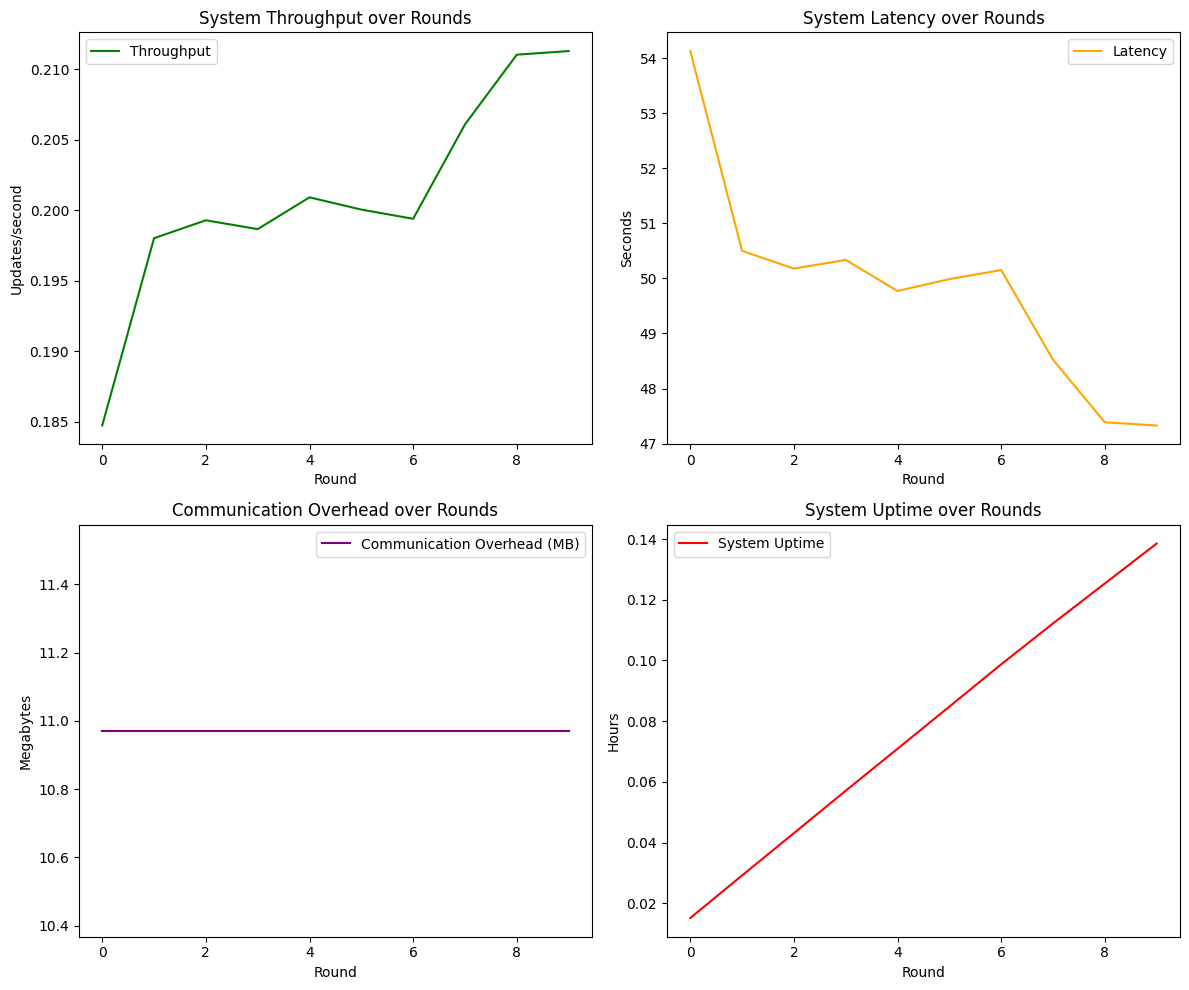


Metrics Summary:
Average Throughput: 0.20 updates/second
Average Latency: 49.83 seconds
Total Communication Overhead: 10.97 MB
Total System Uptime: 0.14 hours
Total Client Failures: 0


In [80]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    drive.mount('/content/drive')

    data_dir = '/content/drive/My Drive/BreastCancerDataset/Dataset_BUSI_with_GT'

    # Training federated system
    metrics = train_federated_system(
        data_dir=data_dir,
        num_clients=10,
        num_rounds=10,
        device=device
    )

    # Plot Metrics
    plot_metrics(metrics)